<a href="https://colab.research.google.com/github/mariamhergnyan/Molecular_Simulations_exam/blob/main/Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these before working.

In [ ]:
!pip install notebook==6.5.5  > /dev/null

In [ ]:
!pip install ipywidgets > /dev/null

In [ ]:
!pip install pyemma > /dev/null
!pip install mdshare > /dev/null
#!pip install MDAnalysis > dev/null
#4 minutes

In [ ]:
!pip install nglview > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 7.1.0 which is incompatible.


In [ ]:
!pip install biopython > /dev/null

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
%matplotlib inline
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
from scipy import interpolate
# for visualization of molecular structures:
import nglview
import mdtraj as md
from threading import Timer
from nglview.player import TrajectoryPlayer
from Bio.PDB import PDBParser
import pyemma.util.contexts as contexts
#import MDAnalysis as mda
import filecmp
from IPython.display import display
from threading import Timer
from google.colab import widgets
import ipywidgets
import warnings
from google.colab import files
import zipfile
from itertools import product


# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
#to deal with numpy's different versions
np.bool = np.bool_
np.float = np.float_

In [ ]:
pdb = '/content/lb6-filtered.pdb'

In [ ]:

# # Load the PDB and trajectory files
# u = md.load(pdb_file)
# traj = md.load(traj_file, top=pdb_file)


# # Specify the frame step size
# frame_step = 252

# # Directory where the output files will be located
# output_dir = 'output_files/'

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Iterate over trajectory frames with the specified frame step
# for i in range(0, len(traj), frame_step):
#     # Write XTC files for each frame
#     output_file_name = output_dir + 'output_{:06d}.xtc'.format(i)
#     md.Trajectory(traj.xyz[i], u.topology).save(output_file_name)

# # Create a zip file containing all output files
# zip_file_name = 'output.zip'
# with zipfile.ZipFile(zip_file_name, 'w') as zipf:
#     for filename in os.listdir(output_dir):
#         zipf.write(os.path.join(output_dir, filename), filename)

# # Download the zip file to the local machine
# files.download(zip_file_name)



In [ ]:
traj_path = '/content/traj_files'

files_and_dirs = os.listdir(traj_path)

#Remove the checkpoint directory if it exists
for item in files_and_dirs:
    if item == '.ipynb_checkpoints':
        checkpoint_path = os.path.join(traj_path, item)
        shutil.rmtree(checkpoint_path)

files = os.listdir(traj_path)
#final paths to the files
files = [os.path.join(traj_path, file) for file in os.listdir(traj_path)]

#Feature selection
Since we don't know which features describe the best the molecule, we do feature selecting with VAMP(Variational Approach for Markov Proceess). We utilize the VAMP2 score which shows the kinetic variance. The minimum VAMP2 score is 1. The higher the score, the better the given feature describes the molecule. Here we only do the selection based on the features of the backbone and not the side chains.

In [ ]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

Obtaining file info:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/5 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/5 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
#compute a cross validated vamp 2 score
    # we temporarily suppress very short-lived progress bars
    with contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

def find_max_vamp_score(data_sets, labels, dims, lags):
    max_score = -float('inf')
    best_property = None
    best_lag = None

    for property_data, property_label in zip(data_sets, labels):
        for lag in lags:
            scores = score_cv(property_data, lag=lag, dim=dims[property_label])
            mean_score = scores.mean()
            if mean_score > max_score:
                max_score = mean_score
                best_property = property_label
                best_lag = lag

    return best_property, best_lag, max_score

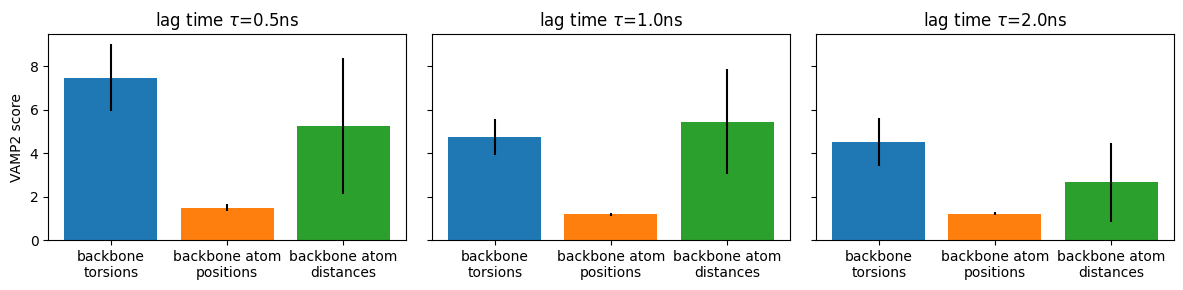

In [ ]:
dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

Trying with different lag times and dimensions

In [ ]:
dims = {'backbone torsions': 10, 'backbone atom positions': 10, 'backbone atom distances': 10}
labels_prime = ['backbone torsions', 'backbone atom positions', 'backbone atom distances']
lags = [2,5,7]
best_property, best_lag, max_score = find_max_vamp_score(
    [torsions_data, positions_data, distances_data],
    labels_prime,
    dims,
    lags
)

print("Property that descrbes the data best:", best_property)
print("Lag time of the highest score:", best_lag)
print("Highest VAMP2 score:", max_score)

# Determine the dataset based on the best property label
if best_property == 'backbone torsions':
  data = torsions_data
elif best_property == 'backbone atom positions':
  data = positions_data
elif best_property == 'backbone atom distances':
  data = distances_data
else:
  raise ValueError("Unknown property label: {}".format(best_property))


Property that descrbes the data best: backbone torsions
Lag time of the highest score: 2
Highest VAMP2 score: 8.815601496036956


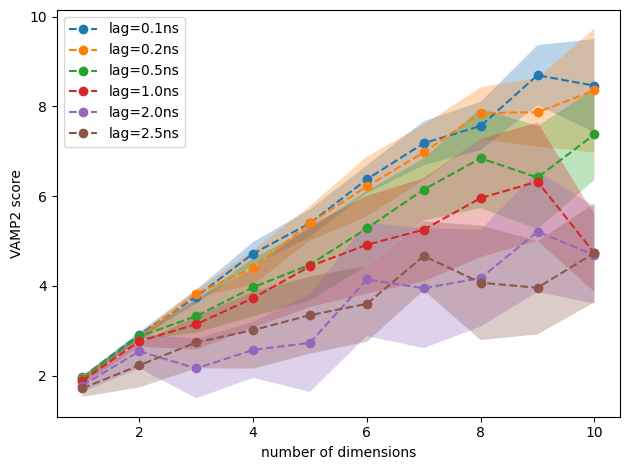

In [ ]:
lags = [1,2,5,10,20,25]
#dims = [1]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = []
    for dim in dims:
      #uncomment for debugging
        #print("Computing VAMP score for dim={}, lag={}".format(dim, lag))
        score = score_cv(data, dim, lag)
        scores_.append(score)
    scores_ = np.array(scores_)

    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()


In [ ]:
#to make my life easier for working with colab
best_lag = 1
data =torsions_data

In [ ]:
tica = pyemma.coordinates.tica(data, lag=best_lag, dim =10)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)


calculate covariances:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/5 [00:00<?, ?it/s]

For torsion angles specifically, IC1 and IC2 would represent linear combinations of torsion angle features that best capture the dominant motions or conformational changes in the molecular system over time. These components may correspond to important collective motions, transitions between different states, or other dynamic behaviors exhibited by the molecular system.

IC1: The first independent component usually captures the slowest process or conformational change in the system. It represents the dominant mode of variation in the input torsion angles.

IC2: The second independent component captures the next slowest process or variation orthogonal to IC1. It represents a secondary mode of motion that is independent of IC1.

Specifically, in this case the ICs represent linear combinations of the original torsion angle features that maximize the variance or capture the most significant correlations in the data while considering the time-lagged dependencies. Therefore, these components provide insight into the dominant patterns of motion or conformational changes exhibited by the molecular system over the course of the simulation.

The distinct regions or clusters in the density plot correspond to different conformational states or basins in the conformational space.
Transitions between states may be represented by regions of lower density or transition regions where densities between different states overlap.

The projection yields defined clusters of high density, which are most likely to be identified as metastable basins.



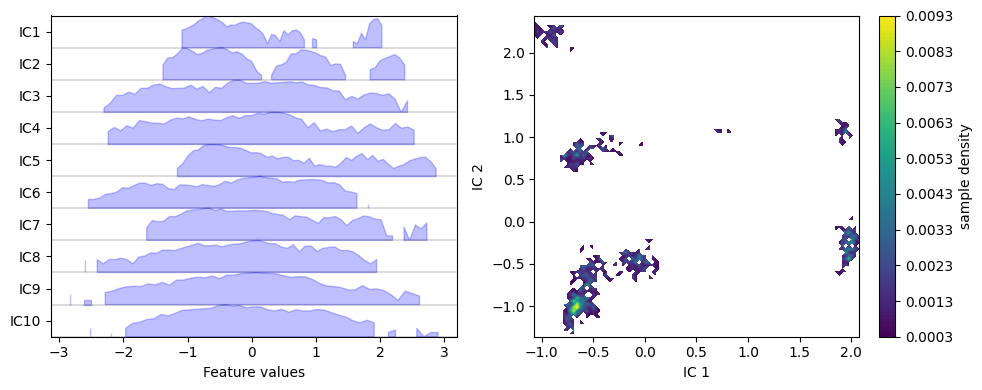

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Determine the number of independent components (ICs)
num_ic = tica_concatenated.shape[1]

# Generate feature labels for the independent components (ICs)
feature_labels = ['IC{}'.format(i + 1) for i in range(num_ic)]

# Plot the feature histograms with the adjusted feature labels
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=feature_labels,
    ylog=True
)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=False) #try without the log scale
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

Each subplot represents the time evolution of one independent component (IC) extracted from the TICA analysis.
The x-axis represents time, and the y-axis represents the magnitude or amplitude of the IC.
By visualizing the time series of each IC, you can identify patterns, fluctuations, and dynamics in the data captured by the TICA transformation.
Peaks, troughs, or patterns in the IC time series may correspond to significant conformational changes, transitions, or dynamics in the molecular system.

Todo: check how many ICs are being created here and if they correspond to all the ones that we have.

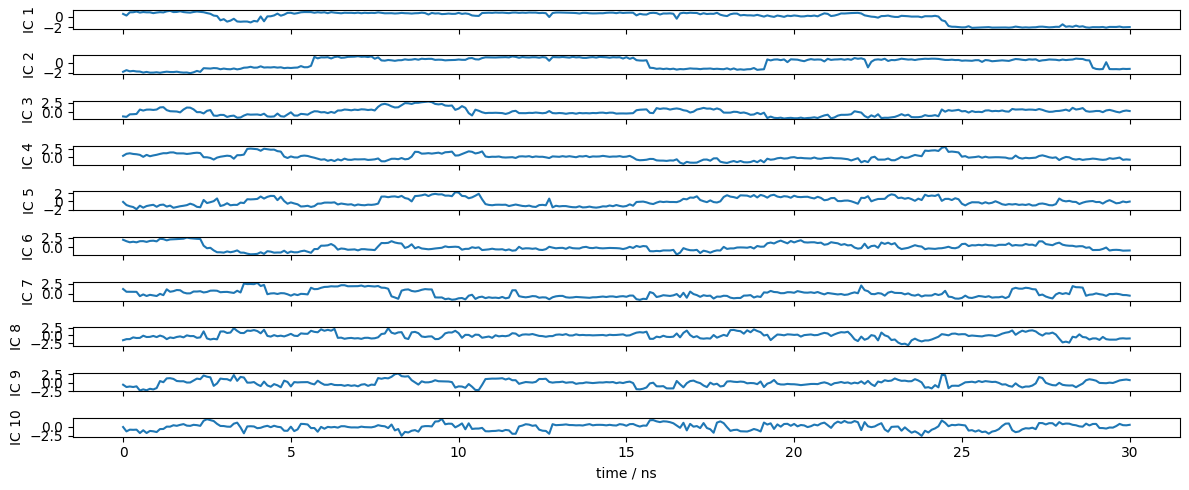

In [ ]:
fig, axes = plt.subplots(tica_output[0].shape[1], 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])

for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))

axes[-1].set_xlabel('time / ns')
fig.tight_layout()


###Discretization
The TICA coordinates now will be put into k discrete states.We have to find at how many states is the VAMP score saturated.
We will set the MSM lag time to TICA lag time.
Besides having an optimal score, we want to obtain a model that describes physically interesting states. Thus, the number of states k
 is often re-adjusted after model inspection.



14-02-24 16:08:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3993] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3997] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4001] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4005] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4009] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4013] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4017] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4021] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4025] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:54 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4029] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


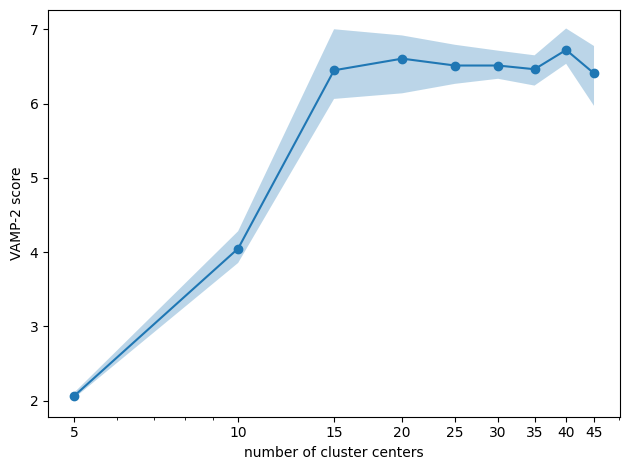

In [ ]:
n_clustercenters = [5, 10, 15,20,25,30, 35,40,45]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50,fixed_seed = 1)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
ax.set_xticks(n_clustercenters)
ax.set_xticklabels(n_clustercenters)
fig.tight_layout()

The VAMP-2 score doesn't saturate much after 20 clusters. But for the best result have fixed the random seed and for the density plot we will use the amount of clusters with the highest VAMP-2 score.

In [ ]:
#again to make my life with colab easier
k = 40
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=k, max_iter=100, stride=50, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|          | 0/45 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/40 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/5 [00:00<?, ?it/s]

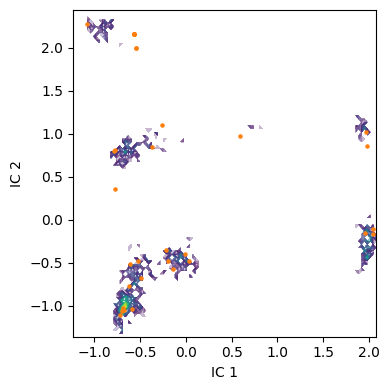

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

We obtain 6 big clusters. Since the kmeans algorithm is stochastic, results may vary from run to run. The random seed is fixed for this purpose.

estimating BayesianMSM:   0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='lag time / ps', ylabel='timescale / ps'>

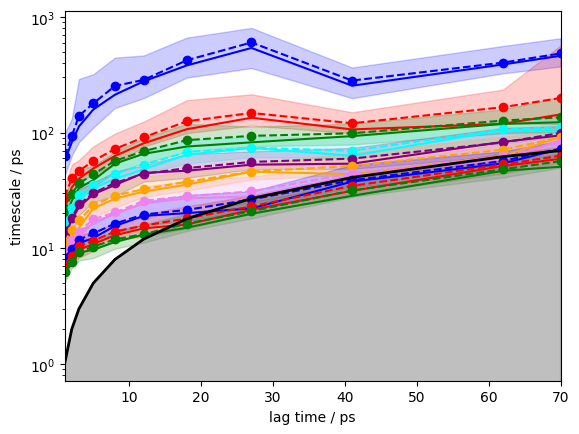

In [ ]:
its = pyemma.msm.its(cluster.dtrajs, lags=70, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ps', dt=1 )

 Implied timescales represent the relaxation timescales of the slowest processes in the system that the MSM captures.

 The lines that are above the gray shaded area are the processes within the ITS, because they are slower than the lag time. The other ones are faster processes therefore can not be resolved.

 As MSMs tend to underestimate the true ITSs, we are looking for a converged maximum in the ITS plot. In our case, any lag time before the slow process (blue line) crosses the lag time threshold (black line) would work. To maximize the kinetic resolution, we choose the lag time 1
 step.

To see whether our model satisfies Markovianity, we perform (and visualize) a Chapman-Kolmogorow (CK) test. Since we aim at modeling the dynamics between metastable states rather than between microstates, this will be conducted in the space of metastable states. The latter are identified automatically using PCCA++. We usually choose the number of metastable states according to the implied timescales plot by identifying a gap between the ITS.

We observe 5(almost 6) resolved processes at approximately 10 ps timescale. And we can also see that the ITS is converging.

In [ ]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=1, dt_traj='0.1 ps')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[15]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

fraction of states used = 1.00
fraction of counts used = 1.00


The fraction is, in both cases, 1
 and, thus, we have no disconnected states (which we would have to exclude from our analysis).

##Chapman-Kolmogorov test

The model is validated with a Chapman-Kolmogorov test. It compares the right and the left side of the Chapman-Kolmogorov equation

T(kτ)=Tk(τ)
with T
 being the transition matrix. PyEMMA automatically estimates a new MSM transition matrix at lag time kτ
 and propagates the original transition matrix by the k
-th power. The highest k
 can be adjusted using the mlags keyword argument of msm.cktest().

We select nstates = 6 becuase from clusterization we obtained more or less 6 discrete states

estimating BayesianMSM:   0%|          | 0/5 [00:00<?, ?it/s]

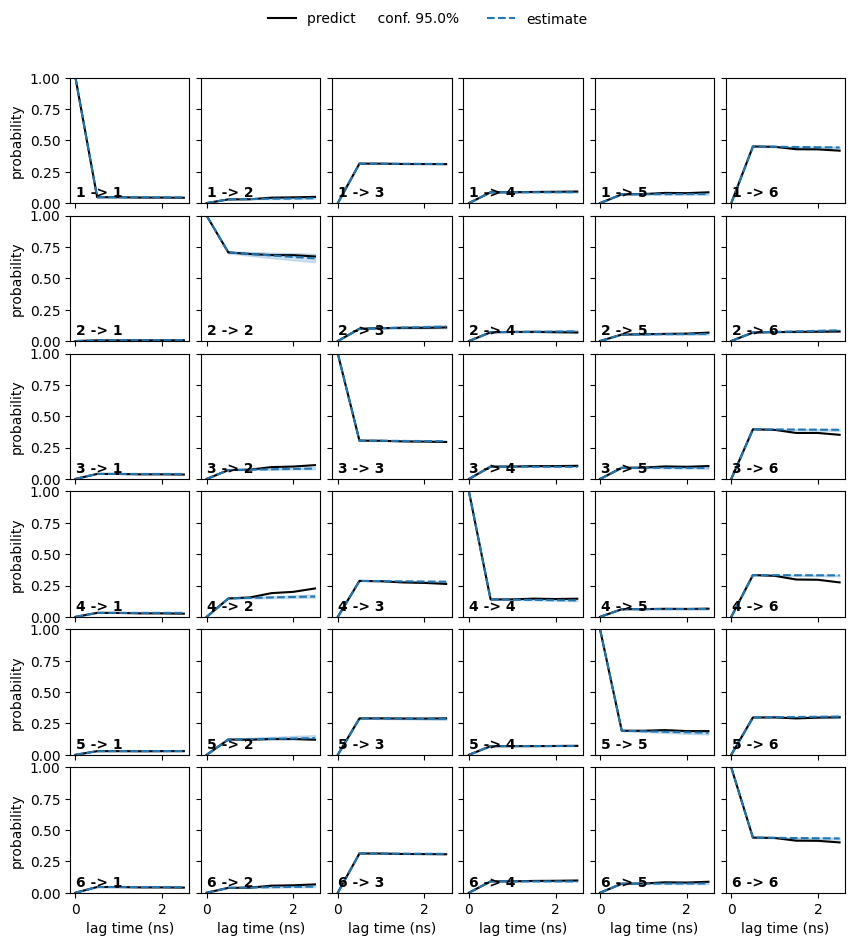

In [ ]:
nstates = 6
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

We can see that there is not too much deviation between the estimate and the prediction. Therefore we can say that we have a good working model.

Time Lagged Correlation: The Chapman-Kolmogorov test helps assess the validity of the Markov assumption at different lag times. It examines whether the probability distributions of observed transitions match the distributions predicted by the Markov model at each lag time.

Interpreting the Plots: The plot generated by plot_cktest typically shows the normalized root mean square deviation (NRMSD) between the estimated transition probabilities at each lag time and those predicted by the model. Lower NRMSD values indicate better agreement between the observed and predicted transition probabilities.

Significance of Deviations: Large deviations between the observed and predicted transition probabilities may indicate violations of the Markov assumption or inaccuracies in the model. These deviations could result from insufficient sampling, model complexity, or limitations in the underlying assumptions.

Higher Transition Probabilities: If you observe that certain transitions have higher probabilities compared to others, it suggests that these transitions are more likely to occur within the system. This information can provide insights into the dynamics and kinetics of the system under study.

In summary, the plots generated by the Chapman-Kolmogorov test help assess the agreement between observed and predicted transition probabilities in a Markov state model. They provide insights into the dynamics and kinetics of the system under study and help evaluate the validity of the underlying assumptions.

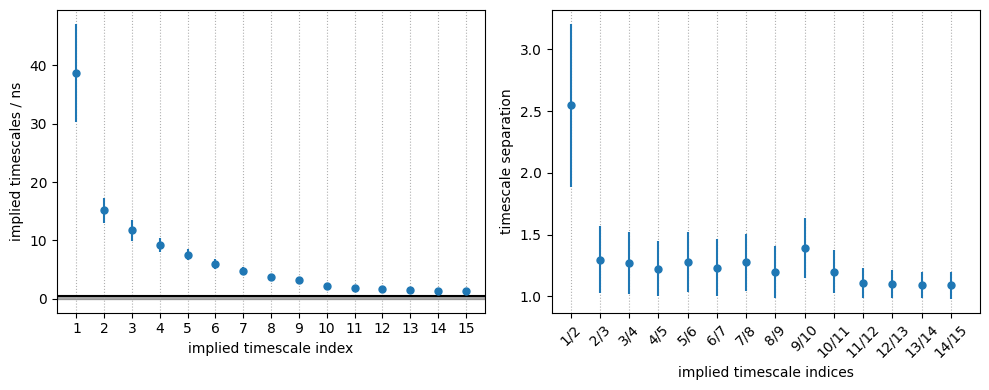

In [ ]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits)],  # Adjusted range
    rotation=45
)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

Separation of Timescales: The separation of timescales refers to the difference in magnitude between consecutive implied timescales. In other words, it measures the relative rates at which different dynamical processes occur within the system.

Interpretation: Large separation between consecutive timescales indicates that there is a significant difference in the rates of the corresponding processes. For example, if the separation between the first and second timescales is large, it suggests that the first process occurs much more slowly compared to the second process.

Significance: Timescale separation is crucial for understanding the hierarchy of dynamical processes within the system. It helps identify the dominant processes governing the system's behavior and provides insights into the complexity of the dynamics.

Error in Timescale Separation: Since implied timescales are estimated from data, there can be uncertainties associated with their values. The error in timescale separatio quantifies the uncertainty in the separation between consecutive timescales due to the error propagation from the standard deviation of the implied timescales.

In [ ]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))

[0.00570317 0.11172422 0.01905343 0.01474368 0.00940168 0.00306725
 0.00339184 0.02522914 0.04543223 0.03262698 0.02090387 0.02680653
 0.00964642 0.01522947 0.0366992  0.02135616 0.07713392 0.0229644
 0.04320889 0.00953173 0.00477213 0.01424028 0.01191809 0.01492482
 0.00811383 0.02223506 0.01003224 0.00747936 0.00775139 0.01900164
 0.01429417 0.03990614 0.02512343 0.03094523 0.01465809 0.01427953
 0.02627705 0.00305427 0.02349371 0.00768692 0.03304008 0.01721967
 0.0279414  0.01077353 0.03698372]
sum of weights = 1.000000


The attribute msm.pi tells us, for each discrete state, the absolute probability of observing said state in global equilibrium. Mathematically speaking, the stationary distribution π
 is the left eigenvector of the transition matrix T
 to the eigenvalue 1
:

π⊤T=π⊤.
We can use the stationary distribution to, e.g., visualize the weight of the dicrete states and, thus, to highlight which areas of our feature space are most probable.

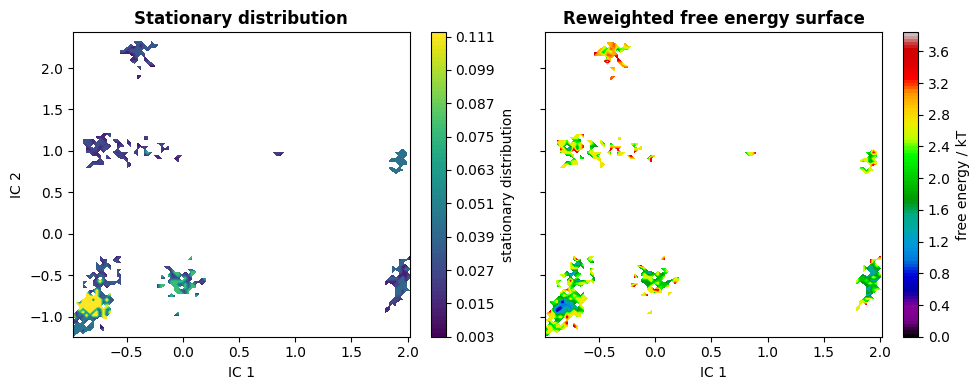

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()


###PCCA

The PCCA++ algorithm computes so called memberships, i.e., the probability of each microstate to belong to a given macrostate. In other words, PCCA++ does a fuzzy assignment of the microstates to macrostates which is encoded in the memberships.



The eigenvectors corresponding to the slowest processes (largest implied timescales) contain information about what configurational changes are happening on which timescales. We analyze the slowest processes by inspecting the value of the first four eigenfunctions projected on two the first TICA coordinates. As the first right eigenvector corresponds to the stationary process (equilibrium), it is constant at 1
.

In [ ]:
# Get the number of states
nstates = len(np.unique(msm.metastable_assignments[dtrajs_concatenated]))
msm.pcca(nstates)

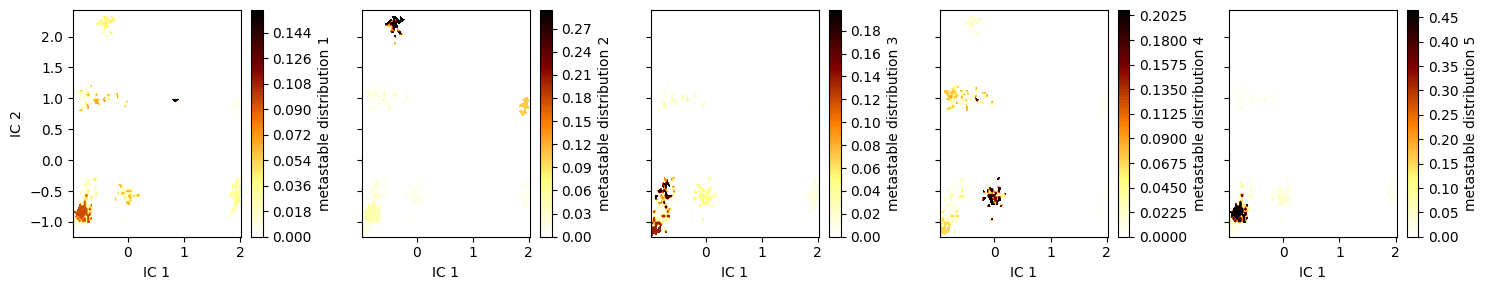

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [ ]:
data_concatenated = np.concatenate(data)
np.shape(data_concatenated)

(2598, 48)

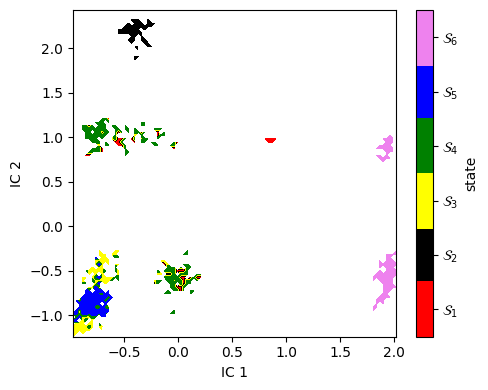

In [ ]:
# Define custom colors for better visibility
colors = ['red', 'black', 'yellow', 'green', 'blue', 'violet']
cmap = plt.cm.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(5, 4))

_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, msm.metastable_assignments[dtrajs_concatenated], ax=ax, cmap=cmap, logscale=False)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()
plt.show()


In [ ]:
files = '/content/lb6-filtered.xtc'
directory = './data/'

In [ ]:
if not os.path.exists(directory):
    os.makedirs(directory)

pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
torsions_source = pyemma.coordinates.source(files, features=torsions_feat)
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=[f'{directory}pcca{n + 1}_10samples.pdb' for n in range(msm.n_metastable)])


['./data/pcca1_10samples.pdb',
 './data/pcca2_10samples.pdb',
 './data/pcca3_10samples.pdb',
 './data/pcca4_10samples.pdb',
 './data/pcca5_10samples.pdb',
 './data/pcca6_10samples.pdb']

This coarse-grained representation of the dynamics is more directly amenable to human interpretation. Nevertheless, as for the conventional MSM, we can still compute several interesting properties. We start with the stationary distribution which encodes the free energy of the states. This can be achieved by summing all the contributions to a coarse-grained state i

In [ ]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.109854	2.208604
2	0.055085	2.898876
3	0.170944	1.766418
4	0.314029	1.158271
5	0.154797	1.865644
6	0.195292	1.633262


MFPT represents the average time it takes for a system to transition from one state to another. Lower MFPT values suggest faster transitions between states, while higher MFPT values indicate slower transitions. Lower MFPT values between certain pairs of states suggest stronger connections or faster transitions between those states. These pairs of states may represent closely related metastable states or states that are energetically favorable to transition between.Paths with lower MFPT values indicate more frequent transitions and potentially more biologically relevant pathways.

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

END
MFPT / ns:


,1,2,3,4,5,6
1,0.00,99.60,8.27,8.89,15.03,27.28
2,20.83,0.00,20.56,13.48,25.97,22.27
3,12.64,104.50,0.00,9.16,15.73,28.00
4,15.30,101.39,12.49,0.00,13.23,34.45
5,15.69,104.77,12.01,6.44,0.00,31.84
6,17.78,83.06,13.89,18.50,23.21,0.00
